# (i) Joint training
### Learning letters + digits after learning digits

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import torch
from torch import Tensor
import torch.nn as nn
import torch.cuda as cuda
import torch.utils.data as data_utils
from torch.utils.data import DataLoader, Dataset
from torch.nn.parameter import Parameter

try:
    import accimage
except ImportError:
    accimage = None

import random
import copy
import time

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.datasets import ImageFolder

from SpykeTorch import snn
from SpykeTorch import functional as sf
from SpykeTorch import visualization as vis
from SpykeTorch import utils

import struct
import glob
import datetime
import re

from sklearn.datasets import fetch_openml
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from PIL import Image

## Model

In [2]:
# Model

class MozafariMNIST2018(nn.Module):
    
    def __init__(self):
        
        super(MozafariMNIST2018, self).__init__()

        self.conv1 = snn.Convolution(6, 30, 5, 0.8, 0.05)
        self.conv1_t = 15
        self.k1 = 5
        self.r1 = 3

        self.conv2 = snn.Convolution(30, 250, 3, 0.8, 0.05)
        self.conv2_t = 10
        self.k2 = 8
        self.r2 = 1

        self.conv3 = snn.Convolution(250, 200, 5, 0.8, 0.05)

        self.stdp1 = snn.STDP(self.conv1, (0.004, -0.003))
        self.stdp2 = snn.STDP(self.conv2, (0.004, -0.003))
        self.stdp3 = snn.STDP(self.conv3, (0.004, -0.003), False, 0.2, 0.8)
        self.anti_stdp3 = snn.STDP(self.conv3, (-0.004, 0.0005), False, 0.2, 0.8)
        self.max_ap = Parameter(torch.Tensor([0.15]))

        self.decision_map = []
        for i in range(10):
            self.decision_map.extend([i]*20)

        self.ctx = {"input_spikes":None, "potentials":None, "output_spikes":None, "winners":None}
        self.spk_cnt1 = 0
        self.spk_cnt2 = 0

    def forward(self, input, max_layer):
        
        input = sf.pad(input.float(), (2,2,2,2), 0)
        
        if self.training:
            pot = self.conv1(input)
            spk, pot = sf.fire(pot, self.conv1_t, True)
            if max_layer == 1:
                self.spk_cnt1 += 1
                if self.spk_cnt1 >= 500:
                    self.spk_cnt1 = 0
                    ap = torch.tensor(self.stdp1.learning_rate[0][0].item(), device=self.stdp1.learning_rate[0][0].device) * 2
                    ap = torch.min(ap, self.max_ap)
                    an = ap * -0.75
                    self.stdp1.update_all_learning_rate(ap.item(), an.item())
                pot = sf.pointwise_inhibition(pot)
                spk = pot.sign()
                winners = sf.get_k_winners(pot, self.k1, self.r1, spk)
                self.ctx["input_spikes"] = input
                self.ctx["potentials"] = pot
                self.ctx["output_spikes"] = spk
                self.ctx["winners"] = winners
                return spk, pot
            
            spk_in = sf.pad(sf.pooling(spk, 2, 2), (1,1,1,1))
            pot = self.conv2(spk_in)
            spk, pot = sf.fire(pot, self.conv2_t, True)
            if max_layer == 2:
                self.spk_cnt2 += 1
                if self.spk_cnt2 >= 500:
                    self.spk_cnt2 = 0
                    ap = torch.tensor(self.stdp2.learning_rate[0][0].item(), device=self.stdp2.learning_rate[0][0].device) * 2
                    ap = torch.min(ap, self.max_ap)
                    an = ap * -0.75
                    self.stdp2.update_all_learning_rate(ap.item(), an.item())
                pot = sf.pointwise_inhibition(pot)
                spk = pot.sign()
                winners = sf.get_k_winners(pot, self.k2, self.r2, spk)
                self.ctx["input_spikes"] = spk_in
                self.ctx["potentials"] = pot
                self.ctx["output_spikes"] = spk
                self.ctx["winners"] = winners
                return spk, pot
            
            spk_in = sf.pad(sf.pooling(spk, 3, 3), (2,2,2,2))
            pot = self.conv3(spk_in)
            spk = sf.fire(pot)
            winners = sf.get_k_winners(pot, 1, 0, spk)
            self.ctx["input_spikes"] = spk_in
            self.ctx["potentials"] = pot
            self.ctx["output_spikes"] = spk
            self.ctx["winners"] = winners
            output = -1
            if len(winners) != 0:
                output = self.decision_map[winners[0][0]]
            return output
        
        else:
            pot = self.conv1(input)
            spk, pot = sf.fire(pot, self.conv1_t, True)
            if max_layer == 1:
                return spk, pot
            
            pot = self.conv2(sf.pad(sf.pooling(spk, 2, 2), (1,1,1,1)))
            spk, pot = sf.fire(pot, self.conv2_t, True)
            if max_layer == 2:
                return spk, pot
            pot = self.conv3(sf.pad(sf.pooling(spk, 3, 3), (2,2,2,2)))
            spk = sf.fire(pot)
            winners = sf.get_k_winners(pot, 1, 0, spk)
            output = -1
            if len(winners) != 0:
                output = self.decision_map[winners[0][0]]
            return output

    def stdp(self, layer_idx):
        if layer_idx == 1:
            self.stdp1(self.ctx["input_spikes"], self.ctx["potentials"], self.ctx["output_spikes"], self.ctx["winners"])
        if layer_idx == 2:
            self.stdp2(self.ctx["input_spikes"], self.ctx["potentials"], self.ctx["output_spikes"], self.ctx["winners"])

    def update_learning_rates(self, stdp_ap, stdp_an, anti_stdp_ap, anti_stdp_an):
        self.stdp3.update_all_learning_rate(stdp_ap, stdp_an)
        self.anti_stdp3.update_all_learning_rate(anti_stdp_an, anti_stdp_ap)

    def reward(self):
        self.stdp3(self.ctx["input_spikes"], self.ctx["potentials"], self.ctx["output_spikes"], self.ctx["winners"])

    def punish(self):
        self.anti_stdp3(self.ctx["input_spikes"], self.ctx["potentials"], self.ctx["output_spikes"], self.ctx["winners"])


In [3]:
# train and test

def train_unsupervise(network, data, layer_idx):
    network.train()
    
    for i in range(len(data)):
        data_in = data[i]
        if use_cuda:
            data_in = data_in.cuda()
        network(data_in, layer_idx)
        network.stdp(layer_idx)

def train_rl(network, data, target):
    network.train()
    perf = np.array([0,0,0]) # correct, wrong, silence
    for i in range(len(data)):
        data_in = data[i]
        target_in = target[i]
        if use_cuda:
            data_in = data_in.cuda()
            target_in = target_in.cuda()
        d = network(data_in, 3)
        if d != -1:
            if d == target_in:
                perf[0]+=1
                network.reward()
            else:
                perf[1]+=1
                network.punish()
        else:
            perf[2]+=1
    return perf/len(data)

def test(network, data, target):
    network.eval()
    perf = np.array([0,0,0]) # correct, wrong, silence
    for i in range(len(data)):
        data_in = data[i]
        target_in = target[i]
        if use_cuda:
            data_in = data_in.cuda()
            target_in = target_in.cuda()
        d = network(data_in, 3)
        if d != -1:
            if d == target_in:
                perf[0]+=1
            else:
                perf[1]+=1
        else:
            perf[2]+=1
    return perf/len(data)

In [4]:
def curve_graph(parametr_set):

    plt.subplots(figsize=(15, 5))

    plt.plot(parametr_set['epoch'], parametr_set['train']*100, color='cyan', label='train')
    plt.plot(parametr_set['epoch'], parametr_set['test']*100, color='blue', marker = 'o', label='test')
    plt.plot(parametr_set['epoch'], parametr_set['test_previous']*100, linestyle = ':', color='red', label='test of previous images')
    plt.xlabel('epochs', loc='right', fontsize=17)
    plt.ylabel('accuracy, %',  loc='top', fontsize=17)
    plt.grid()
    plt.legend()
    plt.show()

In [31]:
# train of 3-rd layer

def third_layer(file_name_net, file_name_csv, adaptive_int, previous_epochs, epochs, 
                train_loader, test_loader, test_previous_loader,
                model, apr, anr, app, anp, parametr_set, 
                steps=None, percent=20, value_for_moved_weights=0.8,
                it_continues=False, freeze_procedure=False):  
    
    '''
    file_name_net - name of file for saving state_dict of model
    file_name_csv - name of file for saving parameters of model in each epoch
    adaptive_int - learning rate parameter
    previous_epochs - if before model had training in current period
    it_continues - is it continue of 3-rd layer training or not (False or True)
    percent - percent of moving weights (calculated from the number of high range weights)
    '''

    adaptive_min=0 

    if not it_continues:

        previous_epochs = 0
        counter = 0

        apr_adapt = ((1.0 - 1.0 / 10) * adaptive_int + adaptive_min) * apr
        anr_adapt = ((1.0 - 1.0 / 10) * adaptive_int + adaptive_min) * anr
        app_adapt = ((1.0 / 10) * adaptive_int + adaptive_min) * app
        anp_adapt = ((1.0 / 10) * adaptive_int + adaptive_min) * anp
        
        best_train = np.array([0.0,0.0,0.0,0.0]) # correct, wrong, silence, epoch
        best_test = np.array([0.0,0.0,0.0,0.0]) # correct, wrong, silence, epoch
        best_test_previous = np.array([0.0,0.0,0.0,0.0]) # correct, wrong, silence, epoch

    else:
      
        if len(parametr_set.loc[parametr_set['test'] == parametr_set['test'].max(), 'epoch']) == 1:
            optim_index = int(parametr_set.loc[parametr_set['test'] == parametr_set['test'].max(), 'epoch'].item())
        else:
            optim_index = int(parametr_set.loc[parametr_set['test'] == parametr_set['test'].max(), 'epoch'].tolist()[-1])

        if len(parametr_set.loc[parametr_set['train'] == parametr_set['train'].max(), 'epoch']) == 1:
            best_train_index = int(parametr_set.loc[parametr_set['train'] == parametr_set['train'].max(), 'epoch'].item())
        else:
            best_train_index = int(parametr_set.loc[parametr_set['train'] == parametr_set['train'].max(), 'epoch'].tolist()[-1])

        if len(parametr_set.loc[parametr_set['test_previous'] == parametr_set['test_previous'].max(), 'epoch']) == 1:
            best_test_previous_index = int(parametr_set.loc[parametr_set['test_previous'] == parametr_set['test_previous'].max(), 'epoch'].item())
        else:
            best_test_previous_index = int(parametr_set.loc[parametr_set['test_previous'] == parametr_set['test_previous'].max(), 'epoch'].tolist()[-1])
        
        max_index = int(parametr_set.index.max())
        counter = (max_index + 1)

        param_best_train = parametr_set['train'].iloc[best_train_index]
        param_best_test = parametr_set['test'].iloc[optim_index]
        param_best_test_previous = parametr_set['test_previous'].iloc[best_test_previous_index]

        apr_adapt = parametr_set['apr_adapt'].iloc[optim_index]
        anr_adapt = parametr_set['anr_adapt'].iloc[optim_index]
        app_adapt = parametr_set['app_adapt'].iloc[optim_index]
        anp_adapt = parametr_set['anp_adapt'].iloc[optim_index]
        
        for i in range(len(model.stdp3.learning_rate)):
            model.stdp3.learning_rate[i][0].fill_(parametr_set['stdp3.learning_rate[0]'].iloc[optim_index])
            model.stdp3.learning_rate[i][1].fill_(parametr_set['stdp3.learning_rate[1]'].iloc[optim_index])
            model.anti_stdp3.learning_rate[0][0].fill_(parametr_set['anti_stdp3.learning_rate[0]'].iloc[optim_index])
            model.anti_stdp3.learning_rate[0][0].fill_(parametr_set['anti_stdp3.learning_rate[1]'].iloc[optim_index])

        best_train = np.array([param_best_train,1-param_best_train,0.0,best_train_index]) # correct, wrong, silence, epoch
        best_test = np.array([param_best_test,1-param_best_test,0.0,optim_index]) # correct, wrong, silence, epoch
        best_test_previous = np.array([param_best_test_previous,1-param_best_test_previous,0.0,best_test_previous_index]) # correct, wrong, silence, epoch
    
    # list of 3-rd layer weights

    dim_0, dim_1, dim_2, dim_3 = tuple(model.conv3.weight.size())
    total_size = dim_0 * dim_1 * dim_2 * dim_3
  
    # indexes of weights
    indexes_i = []    
    indexes_j = []        
    indexes_k = []        
    indexes_m = []    
    
    # values of weights
    item_values = []  
    
    for i in range(dim_0):
        for j in range(dim_1):
            for k in range(dim_2):
                for m in range(dim_3):
                    indexes_i.append(i)
                    indexes_j.append(j)
                    indexes_k.append(k)
                    indexes_m.append(m)
                    item_values.append(model.conv3.weight[i][j][k][m].item())

    indexes_dim_0 = pd.Series(indexes_i, name='dim_0') 
    indexes_dim_1 = pd.Series(indexes_j, name='dim_1')
    indexes_dim_2 = pd.Series(indexes_k, name='dim_2')
    indexes_dim_3 = pd.Series(indexes_m, name='dim_3')
    item_values = pd.Series(item_values, name='value_0')
            
    conv3_data = pd.concat([item_values, indexes_dim_0, indexes_dim_1, indexes_dim_2, indexes_dim_3], axis=1)
    
    high_percent = 85 #percent of high range weights
    percentile_value = np.percentile(item_values, high_percent)
    
    conv3_data['low_range_0'] = 0
    conv3_data.loc[conv3_data['value_0'] < percentile_value,'low_range_0'] = 1
    
    # indexes of freeze weights of third layer before training on the next set                   
    conv3_data['freeze_weights'] = 0
    conv3_data.loc[conv3_data['value_0'] > percentile_value,'freeze_weights'] = 1      
    
    if freeze_procedure:
        print(f"During training {conv3_data['freeze_weights'].sum()} weights "
              f"({conv3_data['freeze_weights'].sum()/total_size*100 :.1f}%) will be freezed")
        
        weights_threshold = nn.Threshold(percentile_value, 0)
        freeze_tensor = weights_threshold(model.conv3.weight)                     
        freeze_list = conv3_data.loc[conv3_data['freeze_weights'] == 1, 'value_0'].to_numpy()
    else:
        freeze_list=[]
        freeze_tensor=None

    try:
        high_range_counter = conv3_data['low_range_0'].value_counts()[0] 
    except:
        high_range_counter = 1
 
    moving_quantity = int((percent/100)*high_range_counter)      #quantity of moving items in each epoch
    #quantity of moving items in each epoch is calculated without taking in account freezed weights
    
    if steps is None:
        steps = int(total_size*high_percent/(100*moving_quantity))   #steps of weights moving 
    elif steps == 0:
        print(f'Training will be performed without weight moving.')
    else:
        print(f'Weight moving will be during {steps} epochs')
    
    for epoch in range(epochs):
        
        seconds_epoch_0 = time.time() 
        
        print('-'*50)
        print("Epoch #: ", epoch + previous_epochs)
        
        perf_train = np.array([0.0,0.0,0.0]) 
        
        for data,targets in train_loader:
                
            if epoch < steps: 
                
                print(f'Values of high range weights in epoch#{epoch} [{percentile_value :.3f}:0.800] (top {100-high_percent}%)')
                low_range_indexes = list(conv3_data.index[(conv3_data['low_range_'+str(epoch)] == 1)&(conv3_data['freeze_weights'] == 0)])
                moving_items = random.sample(low_range_indexes, np.minimum(moving_quantity, len(low_range_indexes)))
                moving_indexes = conv3_data.loc[conv3_data.index.isin(moving_items)]

                print(f'Quantity of moving points in epoch#{epoch + previous_epochs} = {len(moving_indexes.index)} items' 
                      f' ({len(moving_indexes.index)/(total_size-high_range_counter)*100 :.1f}% of moving points)')

                for q in range(len(moving_indexes.index)):
                    model.conv3.weight \
                    [moving_indexes['dim_0'].iloc[q]][moving_indexes['dim_1'].iloc[q]][moving_indexes['dim_2'].iloc[q]][moving_indexes['dim_3'].iloc[q]]. \
                    fill_(np.random.normal(loc=value_for_moved_weights, scale=0.05))  
                
            perf_train_batch = train_rl(model, data, targets)        
    
            if epoch < steps:  
            
                # new values of weights (after learning)
                item_values = []       
                for i in range(dim_0):
                    for j in range(dim_1):
                        for k in range(dim_2):
                            for m in range(dim_3):
                                item_values.append(model.conv3.weight[i][j][k][m].item())
            
                item_values = pd.Series(item_values, name='value_'+str(epoch+1))
                percentile_value = np.percentile(item_values, high_percent) #new cutting off high range weights
                conv3_data = pd.concat([conv3_data, item_values], axis=1)
                
                conv3_data['low_range_'+str(epoch+1)] = 0
                conv3_data.loc[conv3_data['value_'+str(epoch+1)] < percentile_value,'low_range_'+str(epoch+1)] = 1
       
            #update adaptive learning rates
            apr_adapt = apr * (perf_train_batch[1] * adaptive_int + adaptive_min)
            anr_adapt = anr * (perf_train_batch[1] * adaptive_int + adaptive_min)
            app_adapt = app * (perf_train_batch[0] * adaptive_int + adaptive_min)
            anp_adapt = anp * (perf_train_batch[0] * adaptive_int + adaptive_min)
            parametr_set.loc[counter, 'epoch'] = epoch + previous_epochs
            parametr_set.loc[counter, 'apr_adapt'] = apr_adapt
            parametr_set.loc[counter, 'anr_adapt'] = anr_adapt
            parametr_set.loc[counter, 'app_adapt'] = app_adapt
            parametr_set.loc[counter, 'anp_adapt'] = anp_adapt
            parametr_set.loc[counter, 'stdp3.learning_rate[0]'] = model.stdp3.learning_rate[0][0].item()
            parametr_set.loc[counter, 'stdp3.learning_rate[1]'] = model.stdp3.learning_rate[0][1].item()
            parametr_set.loc[counter, 'anti_stdp3.learning_rate[0]'] = model.anti_stdp3.learning_rate[0][0].item()
            parametr_set.loc[counter, 'anti_stdp3.learning_rate[1]'] = model.anti_stdp3.learning_rate[0][1].item()
            parametr_set.loc[counter, 'train'] = perf_train_batch[0]

            model.update_learning_rates(apr_adapt, anr_adapt, app_adapt, anp_adapt)
            perf_train += perf_train_batch
            
        perf_train /= len(train_loader)

        if best_train[0] <= perf_train[0]:
            best_train = np.append(perf_train, epoch + previous_epochs)
        print(f"Current Train: {perf_train[0]*100 :.2f}%")
        #print("   Best Train:", best_train)

        for data,targets in test_loader:
            perf_test = test(model, data, targets)
            parametr_set.loc[counter, 'test'] = perf_test[0]
            if best_test[0] <= perf_test[0]:
                best_test = np.append(perf_test, epoch + previous_epochs)
                torch.save(model.state_dict(), file_name_net)
            print(f"Current Test: {perf_test[0]*100 :.2f}%")
            #print("    Best Test:", best_test)

        if isinstance(test_previous_loader, DataLoader):
            for data,targets in test_previous_loader:
                perf_test_previous = test(model, data, targets)
                parametr_set.loc[counter, 'test_previous'] = perf_test_previous[0]
                if best_test_previous[0] <= perf_test_previous[0]:
                    best_test_previous = np.append(perf_test_previous, epoch + previous_epochs)
                print(f"Current Test Previous: {perf_test_previous[0]*100 :.2f}%")
                #print("    Best Test Previous:", best_test_previous)
                
        else:
            parametr_set.loc[counter, 'test_previous'] = 0
            
        counter += 1
                                                 
        seconds_epoch_1 = time.time()  
        print(f'Operational time of epoch #{epoch + previous_epochs}: '
                  f'{int((seconds_epoch_1 - seconds_epoch_0)//60)} min {int((seconds_epoch_1 - seconds_epoch_0)%60)} sec') 
    
    parametr_set.to_csv(file_name_csv)
    
    print('=='*10, 'SUMMARY', '=='*10)
    print(f"        Best Train: {best_train[0]*100 :.2f}% on {best_train[3] :.0f} epoch")
    print(f"         Best Test: {best_test[0]*100 :.2f}% on {best_test[3] :.0f} epoch")
    print(f"Best Test Previous: {best_test_previous[0]*100 :.2f}% on {best_test_previous[3] :.0f} epoch")
    
    return parametr_set, counter, (previous_epochs+epochs), apr, anr, app, anp, conv3_data

In [6]:
# for image transformation (see dataset)

class S1C1Transform:
    
    def __init__(self, filter, PIL_type=False, timesteps = 15):
        self.PIL_type = PIL_type
        self.to_pil_image = transforms.ToPILImage()    
        self.to_tensor = transforms.ToTensor()
        self.filter = filter
        self.temporal_transform = utils.Intensity2Latency(timesteps)
        self.cnt = 0
        
    def __call__(self, image):
        if self.cnt % 10000 == 0:
            print(f'{self.cnt} images')
        if self.PIL_type:
            image = self.to_pil_image(image)
        self.cnt+=1
        image = self.to_tensor(image) * 255
        image.unsqueeze_(0)
        image = self.filter(image)
        image = sf.local_normalization(image, 8)
        temporal_image = self.temporal_transform(image)
        return temporal_image.sign().byte()

In [7]:
# for image transformation (see dataset)

kernels = [ utils.DoGKernel(3,3/9,6/9),
            utils.DoGKernel(3,6/9,3/9),
            utils.DoGKernel(7,7/9,14/9),
            utils.DoGKernel(7,14/9,7/9),
            utils.DoGKernel(13,13/9,26/9),
            utils.DoGKernel(13,26/9,13/9)]

filter = utils.Filter(kernels, padding = 6, thresholds = 50)

s1c1 = S1C1Transform(filter)
s1c1_PIL = S1C1Transform(filter, PIL_type=True)

In [8]:
# for image transformation (see dataset)

class CustomTensorDataset(Dataset):
    """TensorDataset with support of transforms."""
    
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)

## Sets

### Set of 10 capital letters
24000 train images + 4000 test images

In [10]:
# set of 10 capital letters from EMNIST

path = f'./data/EMNIST_own/capital_letters/'

test_letter_labels = torch.load(f'{path}Mozafari_capital_letters_test_labels.pt', map_location=torch.device('cpu'))
test_letters = torch.load(f'{path}Mozafari_capital_letters_test_images.pt', map_location=torch.device('cpu'))

train_letter_labels = torch.load(f'{path}Mozafari_capital_letters_train_labels.pt', map_location=torch.device('cpu'))
train_letters = torch.load(f'{path}Mozafari_capital_letters_train_images.pt', map_location=torch.device('cpu'))

In [11]:
# Element permutation

train_order_l = torch.randperm(train_letter_labels.shape[0])
test_order_l = torch.randperm(test_letter_labels.shape[0])

train_letter_labels = train_letter_labels[train_order_l].view(train_letter_labels.size())
train_letters = train_letters[train_order_l].view(train_letters.size())

test_letter_labels = test_letter_labels[test_order_l].view(test_letter_labels.size())
test_letters = test_letters[test_order_l].view(test_letters.size())

In [12]:
train_letter_labels.size(), test_letter_labels.size()

(torch.Size([24000]), torch.Size([4000]))

In [13]:
train_letter_set = CustomTensorDataset(tensors=(train_letters, train_letter_labels), transform=s1c1_PIL)
test_letter_set = CustomTensorDataset(tensors=(test_letters, test_letter_labels), transform=s1c1_PIL)

train_letter_loader = DataLoader(train_letter_set, batch_size=len(train_letter_set))
test_letter_loader = DataLoader(test_letter_set, batch_size=len(test_letter_set))

### Set of 10 MNIST digits
Reduction the set of 60000 train + 10000 test images to the set of 24000 train + 4000 test images

In [14]:
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [15]:
# the set of 10 digit images, the same size as the set of letters (2400 trains + 400 tests per class)
# the MNIST data was pre-divided into 10 classes
path = f'./data/MNIST_0_1_2_3_4_5_6_7_8_9/'

for i in classes: 
    globals()[f'train_digit_{i}_images'] = torch.load(f'{path}train_images_{i}.pt', map_location=torch.device('cpu'))[0:2400]
    globals()[f'train_digit_{i}_labels'] = torch.load(f'{path}train_labels_{i}.pt', map_location=torch.device('cpu'))[0:2400]
    globals()[f'test_digit_{i}_images'] = torch.load(f'{path}test_images_{i}.pt', map_location=torch.device('cpu'))[0:400]
    globals()[f'test_digit_{i}_labels'] = torch.load(f'{path}test_labels_{i}.pt', map_location=torch.device('cpu'))[0:400]

train_MNIST_labels = globals()[f'train_digit_0_labels']
train_MNIST_images = globals()[f'train_digit_0_images']
test_MNIST_labels = globals()[f'test_digit_0_labels']
test_MNIST_images = globals()[f'test_digit_0_images']                                 

for i in range(1, 10):
    train_MNIST_labels = torch.cat((train_MNIST_labels, globals()[f'train_digit_{i}_labels']), 0)
    train_MNIST_images = torch.cat((train_MNIST_images, globals()[f'train_digit_{i}_images']), 0)

    test_MNIST_labels = torch.cat((test_MNIST_labels, globals()[f'test_digit_{i}_labels']), 0)
    test_MNIST_images = torch.cat((test_MNIST_images, globals()[f'test_digit_{i}_images']), 0)

In [16]:
train_MNIST_labels.size(), test_MNIST_labels.size()

(torch.Size([24000]), torch.Size([4000]))

In [17]:
# Element permutation

train_order = torch.randperm(train_MNIST_labels.shape[0])
test_order = torch.randperm(test_MNIST_labels.shape[0])

train_MNIST_labels = train_MNIST_labels[train_order].view(train_MNIST_labels.size())
train_MNIST_images = train_MNIST_images[train_order].view(train_MNIST_images.size())

test_MNIST_labels = test_MNIST_labels[test_order].view(test_MNIST_labels.size())
test_MNIST_images = test_MNIST_images[test_order].view(test_MNIST_images.size())

In [18]:
train_MNIST_set = CustomTensorDataset(tensors=(train_MNIST_images, train_MNIST_labels), transform=s1c1_PIL)
test_MNIST_set = CustomTensorDataset(tensors=(test_MNIST_images, test_MNIST_labels), transform=s1c1_PIL)

train_MNIST_loader = DataLoader(train_MNIST_set, batch_size=len(train_MNIST_set))
test_MNIST_loader = DataLoader(test_MNIST_set, batch_size=len(test_MNIST_set))

### Combined set of digits + capital letters

48000 train + 8000 test images

In [19]:
train_combi_labels = torch.cat((train_MNIST_labels, train_letter_labels), 0)
train_combi_images = torch.cat((train_MNIST_images, train_letters), 0)

test_combi_labels = torch.cat((test_MNIST_labels, test_letter_labels), 0)
test_combi_images = torch.cat((test_MNIST_images, test_letters), 0)

# Element permutation

train_order_c = torch.randperm(train_combi_labels.shape[0])
test_order_c = torch.randperm(test_combi_labels.shape[0])

train_combi_labels = train_combi_labels[train_order_c].view(train_combi_labels.size())
train_combi_images = train_combi_images[train_order_c].view(train_combi_images.size())

test_combi_labels = test_combi_labels[test_order_c].view(test_combi_labels.size())
test_combi_images = test_combi_images[test_order_c].view(test_combi_images.size())

In [20]:
train_combi_set = CustomTensorDataset(tensors=(train_combi_images, \
                                                train_combi_labels), transform=s1c1_PIL)
test_combi_set = CustomTensorDataset(tensors=(test_combi_images, \
                                                test_combi_labels), transform=s1c1_PIL)

train_combi_loader = DataLoader(train_combi_set, batch_size=len(train_combi_set))
test_combi_loader = DataLoader(test_combi_set, batch_size=len(test_combi_set))

## Model activation

In [21]:
mozafari = MozafariMNIST2018()

In [22]:
use_cuda = True

if torch.cuda.is_available():
    print("CUDA is available")
    device = torch.device("cuda")

CUDA is available


In [23]:
if use_cuda:
    mozafari.cuda()   

mozafari.eval()

MozafariMNIST2018(
  (conv1): Convolution()
  (conv2): Convolution()
  (conv3): Convolution()
  (stdp1): STDP(
    (conv_layer): Convolution()
  )
  (stdp2): STDP(
    (conv_layer): Convolution()
  )
  (stdp3): STDP(
    (conv_layer): Convolution()
  )
  (anti_stdp3): STDP(
    (conv_layer): Convolution()
  )
)

## Continuous learning 
Training on set of digits + capital letters after training on digits

### Saving parameters before training on digits

In [24]:
learning_rate_from_scratch = {'stdp1': [mozafari.stdp1.learning_rate[0][0].item(), 
                                        mozafari.stdp1.learning_rate[0][1].item()],
                              'stdp2': [mozafari.stdp2.learning_rate[0][0].item(), 
                                        mozafari.stdp2.learning_rate[0][1].item()],
                              'stdp3': [mozafari.stdp3.learning_rate[0][0].item(), 
                                        mozafari.stdp3.learning_rate[0][1].item()],
                              'anti_stdp3': [mozafari.anti_stdp3.learning_rate[0][0].item(), 
                                             mozafari.anti_stdp3.learning_rate[0][1].item()]
                             }

### Installation of SNN trained on 24,000 images of digits

In [25]:
# file "saved_24000_digits.net" is the result of the file "Initial_learning_of_SNN_on_digits.ipynb"
mozafari.load_state_dict(torch.load("saved_24000_digits.net"))

<All keys matched successfully>

### Training the first layer

In [26]:
print("Training the first layer")

for epoch in range(2):
    print("Epoch", epoch)
    iter = 0
    for data, targets in train_combi_loader:
        print("Iteration", iter)
        train_unsupervise(mozafari, data, 1)
        print("Done!")
        iter+=1

Training the first layer
Epoch 0
0 images
10000 images
20000 images
30000 images
40000 images
Iteration 0
Done!
Epoch 1
50000 images
60000 images
70000 images
80000 images
90000 images
Iteration 0
Done!


### Training the second layer

In [27]:
print("Training the second layer")

for epoch in range(4):
    print("Epoch", epoch)
    iter = 0
    for data,targets in train_combi_loader:
        print("Iteration", iter)
        train_unsupervise(mozafari, data, 2)
        print("Done!")
        iter+=1

Training the second layer
Epoch 0
100000 images
110000 images
120000 images
130000 images
140000 images
Iteration 0
Done!
Epoch 1
150000 images
160000 images
170000 images
180000 images
190000 images
Iteration 0
Done!
Epoch 2
200000 images
210000 images
220000 images
230000 images
Iteration 0
Done!
Epoch 3
240000 images
250000 images
260000 images
270000 images
280000 images
Iteration 0
Done!


### Training the third layer

In [28]:
# moving learning_rates 

for i in range(len(mozafari.stdp3.learning_rate)):
                    mozafari.stdp3.learning_rate[i][0].fill_(learning_rate_from_scratch['stdp3'][0])
                    mozafari.stdp3.learning_rate[i][1].fill_(learning_rate_from_scratch['stdp3'][1])
                    mozafari.anti_stdp3.learning_rate[i][0].fill_(learning_rate_from_scratch['anti_stdp3'][0])
                    mozafari.anti_stdp3.learning_rate[i][1].fill_(learning_rate_from_scratch['anti_stdp3'][1])

In [29]:
# initial adaptive learning rates

apr = mozafari.stdp3.learning_rate[0][0].item()
anr = mozafari.stdp3.learning_rate[0][1].item()
app = mozafari.anti_stdp3.learning_rate[0][1].item()
anp = mozafari.anti_stdp3.learning_rate[0][0].item()
               
parametr_set = pd.DataFrame(columns=['epoch', 'train', 'test', 'test_previous',   
                                 'apr_adapt', 'anr_adapt', 'app_adapt', 'anp_adapt', 
                                 'stdp3.learning_rate[0]', 'stdp3.learning_rate[1]',
                                 'anti_stdp3.learning_rate[0]', 'anti_stdp3.learning_rate[1]'])

In [32]:
# train the 3-rd layer

first_test = third_layer(file_name_net="saved_letter+digit_after_digit_total_0.net",
                        file_name_csv='parameter_set_letter+digit_after_digit_0.csv',
                        adaptive_int=0.5, previous_epochs=0, epochs=100, 
                        train_loader=train_combi_loader, 
                        test_loader=test_letter_loader, 
                        test_previous_loader=test_MNIST_loader,
                        model=mozafari, apr=apr, anr=anr, app=app, anp=anp, 
                        parametr_set=parametr_set, steps=0, percent=0, it_continues=False)

parametr_set = first_test[0] 
counter = first_test[1] 
previous_epochs = first_test[2]
apr = first_test[3] 
anr = first_test[4] 
app = first_test[5] 
anp = first_test[6]
conv3_data_train = first_test[7]

Training will be performed without weight moving.
--------------------------------------------------
Epoch #:  0
340000 images
350000 images
360000 images
370000 images
380000 images
Current Train: 66.36%
Current Test: 51.30%
390000 images
Current Test Previous: 85.32%
Operational time of epoch #0: 3 min 36 sec
--------------------------------------------------
Epoch #:  1
400000 images
410000 images
420000 images
430000 images
Current Train: 71.35%
440000 images
Current Test: 52.12%
Current Test Previous: 87.35%
Operational time of epoch #1: 3 min 52 sec
--------------------------------------------------
Epoch #:  2
450000 images
460000 images
470000 images
480000 images
490000 images
Current Train: 72.48%
Current Test: 53.97%
500000 images
Current Test Previous: 88.80%
Operational time of epoch #2: 3 min 49 sec
--------------------------------------------------
Epoch #:  3
510000 images
520000 images
530000 images
540000 images
550000 images
Current Train: 73.57%
Current Test: 55.23%

2080000 images
2090000 images
2100000 images
2110000 images
Current Train: 83.85%
2120000 images
Current Test: 71.80%
Current Test Previous: 91.05%
Operational time of epoch #31: 3 min 36 sec
--------------------------------------------------
Epoch #:  32
2130000 images
2140000 images
2150000 images
2160000 images
2170000 images
Current Train: 84.02%
Current Test: 71.92%
2180000 images
Current Test Previous: 91.00%
Operational time of epoch #32: 3 min 38 sec
--------------------------------------------------
Epoch #:  33
2190000 images
2200000 images
2210000 images
2220000 images
2230000 images
Current Train: 84.12%
Current Test: 72.00%
Current Test Previous: 90.90%
Operational time of epoch #33: 3 min 42 sec
--------------------------------------------------
Epoch #:  34
2240000 images
2250000 images
2260000 images
2270000 images
2280000 images
Current Train: 84.24%
2290000 images
Current Test: 72.28%
Current Test Previous: 90.97%
Operational time of epoch #34: 3 min 45 sec
----------

3810000 images
3820000 images
3830000 images
3840000 images
3850000 images
Current Train: 87.24%
Current Test: 78.10%
3860000 images
Current Test Previous: 91.53%
Operational time of epoch #62: 3 min 38 sec
--------------------------------------------------
Epoch #:  63
3870000 images
3880000 images
3890000 images
3900000 images
3910000 images
Current Train: 87.31%
Current Test: 78.17%
Current Test Previous: 91.57%
Operational time of epoch #63: 3 min 37 sec
--------------------------------------------------
Epoch #:  64
3920000 images
3930000 images
3940000 images
3950000 images
3960000 images
Current Train: 87.42%
3970000 images
Current Test: 78.27%
Current Test Previous: 91.57%
Operational time of epoch #64: 3 min 38 sec
--------------------------------------------------
Epoch #:  65
3980000 images
3990000 images
4000000 images
4010000 images
4020000 images
Current Train: 87.46%
Current Test: 78.42%
4030000 images
Current Test Previous: 91.65%
Operational time of epoch #65: 3 min 37

5550000 images
5560000 images
5570000 images
5580000 images
5590000 images
Current Train: 89.44%
Current Test: 80.60%
Current Test Previous: 91.90%
Operational time of epoch #93: 3 min 38 sec
--------------------------------------------------
Epoch #:  94
5600000 images
5610000 images
5620000 images
5630000 images
5640000 images
Current Train: 89.41%
5650000 images
Current Test: 80.62%
Current Test Previous: 92.15%
Operational time of epoch #94: 3 min 38 sec
--------------------------------------------------
Epoch #:  95
5660000 images
5670000 images
5680000 images
5690000 images
5700000 images
Current Train: 89.42%
Current Test: 80.53%
5710000 images
Current Test Previous: 92.07%
Operational time of epoch #95: 3 min 38 sec
--------------------------------------------------
Epoch #:  96
5720000 images
5730000 images
5740000 images
5750000 images
Current Train: 89.51%
5760000 images
Current Test: 80.55%
Current Test Previous: 92.10%
Operational time of epoch #96: 3 min 38 sec
----------

## Results chart

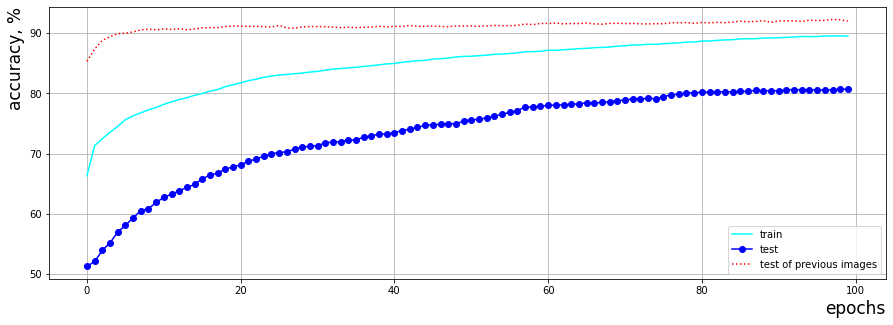

In [33]:
curve_graph(parametr_set)